<a href="https://colab.research.google.com/github/Taeyoung90/pytorch_firststep/blob/main/pytorch_firststep4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision.models as models

In [ ]:
resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#resnet모델의 직속 child node
for name, module in resnet.named_children():
  print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
import torch
import torch.nn as nn

class Resnet(nn.Module):
  def __init__(self):
    super(Resnet, self).__init__()
    self.layer0 = nn.Sequential(*list(resnet.children())[0:-1]) #resnet.children()은 학습된 모듈의 변수들이 포함되어 있고 이를 list로 만들고나서 *로 언패킹함
    self.layer1 = nn.Sequential(
        nn.Linear(2048, 500),
        nn.BatchNorm1d(500),
        nn.ReLU(),
        nn.Linear(500,num_category),
        nn.ReLU()
    )

  def forward(self,x):
    out = self.layer0(x)
    out = out.view(batch_size,-1)
    out = self.layer1(out)
    return out

In [ ]:
#학습의 대상이 되는 변수 범위를 정하기
for params in model.layer0.parameters(): # 모델freezing
  params.requires_grad = False

for params in model.layer1.parameters(): # 모델 unfreezing 
  params.requires_grad = True

NameError: ignored

#Image Style Transfer
StyleTransfer_LBFGS_gps

In [1]:
!pip install torch torchvision

In [2]:
#필요한 이미지 다운

!rm -r images
import os

try:
  os.mkdir('images')
  os.mkdir('images/content')
  os.mkdir('images/style')
except:
  pass

!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -P images/content
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -P images/style

rm: cannot remove 'images': No such file or directory
--2021-09-06 15:00:02--  https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406531 (397K) [image/jpeg]
Saving to: ‘images/content/Tuebingen_Neckarfront.jpg’

Tuebingen_Neckarfro 100%[===================>] 397.00K  --.-KB/s    in 0.1s    

2021-09-06 15:00:03 (3.49 MB/s) - ‘images/content/Tuebingen_Neckarfront.jpg’ saved [406531/406531]

--2021-09-06 15:00:03--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)

## 1. Settings

### 1) Import required libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

### 2) Hyperparameter

In [4]:
# 컨텐츠 손실을 어느 지점에서 맞출것인지를 지정
content_layer_num = 1
image_size= 512
epoch = 5000

## 2. Data

### 1) Directory

In [5]:
content_dir = "./images/content/Tuebingen_Neckarfront.jpg"
style_dir = "./images/style/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

### 2) Preprocessing Func
- 전처리 함수


In [6]:
#이미 학습된 ResNet 모델이 이미지넷으로 학습된 모델이기 때문에 이에 따라 정규화해줌

def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                         std=[1,1,1]),
                ])
    img = transform(img).view((-1,3,image_size,image_size))
    return img

## 3) Post processing Func
- 후처리 함수

In [7]:
# 정규화 된 상태로 연산을 진행하고 다시 이미지화 해서 보기위해 뺏던 값들을 다시 더해줌
# 또한 이미지가 0에서 1사이의 값을 가지게 해줌

def image_postprocess(tensor):
  transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], std=[1,1,1])
  img = transform(tensor.clone())
  img = img.clamp(0,1) #min, max범위안에 들어가도록 변경, min보다 작으면 min값으로 max보다 크면 max값으로 변경
  img = torch.transpose(img,0,1) # img의  0차원과 1차원을 바꿈
  img = torch.transpose(img,1,2) # img의 1차원과 2차원을 바꿈
  return img

In [ ]:
hwc_img_data = torch.rand(100, 64, 32, 3)

In [ ]:
hwc_img_data.size()

torch.Size([100, 64, 32, 3])

In [ ]:
torch.transpose(hwc_img_data,0,1).size()

torch.Size([64, 100, 32, 3])

# 3.Model & Loss Func
## 1) Resnet

In [8]:
# 미리 학습된 resnet50를 사용
resnet = models.resnet50(pretrained=True)
for name,module in resnet.named_children():
  print(name)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


## 2) Delete Fully Connected Layer

In [9]:
# 레이어마다 결과값을 가져올 수 있게 forward를 정의함

class Resnet(nn.Module):
  def __init__(self):
    super(Resnet,self).__init__()
    self.layer0 = nn.Sequential(*list(resnet.children())[0:1]) # 0번째 layer
    self.layer1 = nn.Sequential(*list(resnet.children())[1:4]) # 1~3 layer
    self.layer2 = nn.Sequential(*list(resnet.children())[4:5]) # 4 layer
    self.layer3 = nn.Sequential(*list(resnet.children())[5:6]) # 5 layer
    self.layer4 = nn.Sequential(*list(resnet.children())[6:7]) # 6 layer
    self.layer5 = nn.Sequential(*list(resnet.children())[7:8]) # 7 layer

  def forward(self,x):
    out_0 = self.layer0(x)
    out_1 = self.layer1(out_0)
    out_2 = self.layer2(out_1)
    out_3 = self.layer3(out_2)
    out_4 = self.layer4(out_3)
    out_5 = self.layer5(out_4)
    return out_0, out_1, out_2, out_3, out_4, out_5

## 3) Gram Matrix Func

In [10]:
# 그람 행렬을 생성하는 클래스 및 함수 정의
# [batch,channel, height, width] > [b,c, h*w]
# [b,c, h*w] * [b,h*w, c] = [b,c,c]

class GramMatrix(nn.Module):
  def forward(self, input):
    b,c,h,w = input.size()
    F = input.view(b,c, h*w)
    G = torch.bmm(F, F.transpose(1,2))
    return G

## 4) Model on GPU

In [11]:
# 모델을 합습의 대상이 아니기 때문에 required_grad를 False로 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

resnet = Resnet().to(device)
for param in resnet.parameters():
  param.required_grad = False #resnet 파라미터들이 업데이트되지 않게 함

cuda:0


## 5) Gram Matrix Loss

In [12]:
# 그람행렬간의 손실을 계산하는 클래스 및 함수 정의

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

# 4. Train
## 1) Prepare Images

False False True


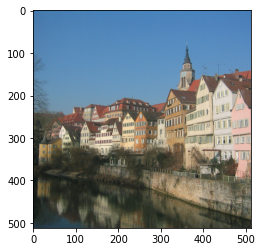

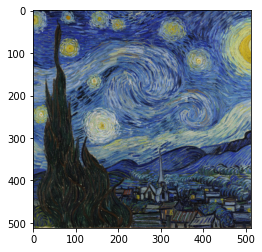

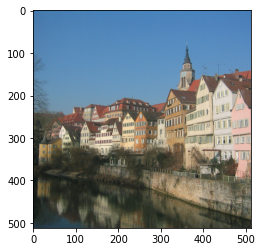

In [13]:
# 컴텐츠 이미지, 스타일 이밎, 학습의 대상이 되는 이미지 정의

content = image_preprocess(content_dir).to(device)
style = image_preprocess(style_dir).to(device)
generated = content.clone().requires_grad_().to(device)

print(content.requires_grad,style.requires_grad,generated.requires_grad)

#시각화

plt.imshow(image_postprocess(content[0].cpu()))
plt.show()

plt.imshow(image_postprocess(style[0].cpu()))
plt.show()

gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.imshow(gen_img)
plt.show()

## 2) Set Targets & Style Weights

In [14]:
# 목표값을 설정하고 행렬의 크기에 따른 가중치도 함께 정의해놓습니다


style_target = list(GramMatrix().to(device)(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 3) Train

In [15]:
#LBFGS 최적화 함수를 사용
# 이때 학습의 대상은 모델의 가중치가 아닌 이미지 자체

optimizer = optim.LBFGS([generated])

iteration = [0]
while iteration[0] < epoch:
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        
        # 스타일 손실을 각각의 목표값에 따라 계산하고 이를 리스트로 저장합니다.
        style_loss = [GramMSELoss().to(device)(out[i],style_target[i])*style_weight[i] for i in range(len(style_target))]
        
        # 컨텐츠 손실은 지정한 위치에서만 계산되므로 하나의 수치로 저장됩니다.
        content_loss = nn.MSELoss().to(device)(out[content_layer_num],content_target)
        
        # 스타일:컨텐츠 = 1000:1의 비중으로 총 손실을 계산합니다.
        total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)
        total_loss.backward(retain_graph=True)

        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss

    optimizer.step(closure)

tensor(1507036.6250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(45.8206, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.6150, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7416, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4422, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9393, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3546, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3063, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2707, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2439, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2073, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1816, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1721, device='cuda:0', grad_fn=<

# 5. Check Results

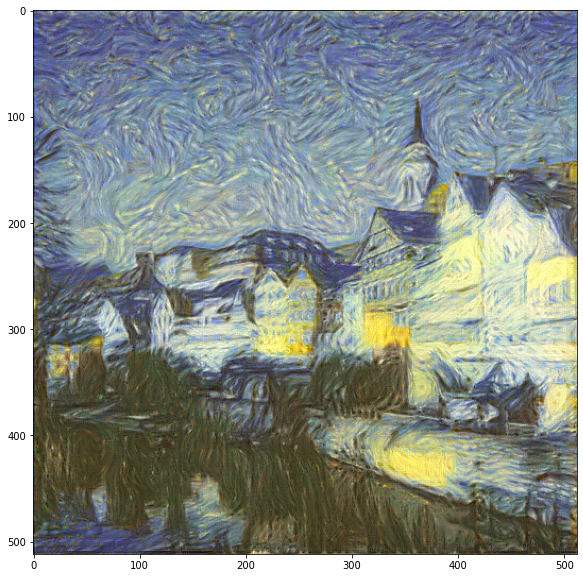

In [16]:
# 학습된 결과 이미지 확인

gen_img = image_postprocess(generated[0].cpu()).data.numpy()

plt.figure(figsize=(10,10))
plt.imshow(gen_img)
plt.show()